# Econ570 Assignment 2

In [1]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
style.use("fivethirtyeight")
random.seed(10)

In [3]:
## helper functions

def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

def fn_generate_cov(dim, corr):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar, corr)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

# Q1
$y_i = \tau*T_i+\beta'*x_i+e_i$

In [4]:
## define a function to simulate data y
def fn_generate_y(T,X,C,tau,N,p,corr,conf = True,conx = True,contf = True,contx = True):
    """
    T: treatment effect
    X: observed covariates
    C: confounders
    tau: treatment effect parameter
    N: sample size
    p: number of covariates
    corr: correlation for multivariate normal
    conf: indicating the existence of confounding factors
    conx: indicating the existence of covariates factors
    contx: indicating whether we control the covariates
    contf: indicating whether we control the confoundings
    """


    corr = 0.5 

    if conf == False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1

    if conx == False:
        conx_mult = 0 # remove observed covariates from outcome
    else:
        conx_mult = 1


    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1]) #the matrix of true parameters of the observed covariates

    Yab = tau*T+conx_mult*X@beta0+conf_mult*0.6*C+err
    
    if contf == False:
        C = np.zeros([N,1]) 
        
    if contx == False:
        X = np.zeros([N,1])

    
    if conf == True:
        return (Yab, T, C)

    if conx == True:
        return (Yab, T, X)

In [5]:
## define a function to simulate data y,T,x
def fn_generate_data(tau,N,p,corr,conf = True,conx = True,contf = True,contx = True):
    
    nvar = p+1 # 1 confounder and variable for randomizing treatment
    
    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,0].reshape([N,1])
    
    X = allX[:,1:] 
    T = fn_randomize_treatment(N)
    
    Y, T, X = fn_generate_y(T,X,C,tau,N,p,corr,conf,conx,contf,contx)
    
    return Y, T, X

In [6]:
# Simulate a DGP

tau = 2
N = 100
p = 1

Y, T, X = fn_generate_data(tau,N,p, corr = 0.5,conf = False,conx = True,contf = False,contx = True)


matrix = np.hstack([Y,T,X])
data_Q1 = pd.DataFrame(matrix, columns=['Y', 'T', 'X'])
data_Q1.to_csv("data_Q1.csv",index = False)

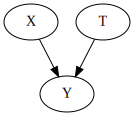

In [7]:
# Illustrate DGP with a DAG
g = gr.Digraph()
g.edge("X", "Y")
g.edge("T", "Y")
g

## Monte Carlo Experiment

In [8]:
## define a function to estimate the treatment effect of random sample using OLS
def fn_estimate_params(Y,T,X):
    """
    Y: Outcome value of Dependent Variable
    T: Indicating the treatment group 0/1
    X: Value of observed covariates/Value of Confounders
    """

    mod = sm.OLS(Y,T,X)
    res = mod.fit()
    tauhat = res.params[0]
    se_tauhat = res.HC1_se[0]

    return tauhat,se_tauhat

In [9]:
## define a function to do the monte carlo simulation
def run_mc_simulation(R,tau,N,p,corr,conf = False,conx = False,contf = True,contx = True):
    """
    R: number of MC replications
    tau: treatment effect parameter
    N: sample size
    p: number of covariates
    corr: Correlation for multivariate normal
    conf: Indicating the existence of confounding factors
    conx: Indicating the existence of covariates factors
    contx: Indicating whether we control the covariates
    contf: Indicating whether we control the confoundings
    """

    estDict = {}
    for n in N:
        tauhats = []
        sehats = []
        for r in tqdm(range(R)):
            Y,T,X = fn_generate_data(tau,n,p,corr,conf,conx,contf,contx)
            tauhat,sehat = fn_estimate_params(Y,T,X)
            tauhats = tauhats + [tauhat]
            sehats = sehats + [sehat]
        estDict[n] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
        }

    return estDict

In [10]:
# define a function to summarize the results of monte carlo simulation
def summarize_mc_simulation(tau,R,N,estDict):
    tau0 = tau*np.ones([R,1])
    for N, results in estDict.items():
        (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                             results['sehat'])

        print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    return

### case a : without control for any covariates

In [11]:
n_rep = 2000
tau = 2
N = [100,1000]
p = 1

estDict = run_mc_simulation(n_rep,tau,N,p,corr = 0.5,conf = False,conx = True,contx = False,contf = False)
summarize_mc_simulation(tau,n_rep,N,estDict)

100%|██████████| 2000/2000 [00:34<00:00, 57.67it/s]

N=100: bias=0.015907258340033318, RMSE=1.0290427723630646, size=0.0635
N=1000: bias=0.0003878033833572725, RMSE=0.3110486793070965, size=0.0505


### case b : with control for all the covariates that affect the outcome

In [12]:
n_rep = 2000
tau = 2
N = [100,1000]
p = 1

estDict = run_mc_simulation(n_rep,tau,N,p,corr=0.5,conf = False,conx = True,contf = False,contx = True)
summarize_mc_simulation(tau,n_rep,N,estDict)

100%|██████████| 2000/2000 [00:21<00:00, 91.43it/s] 

N=100: bias=0.009545002275571875, RMSE=1.037376451010417, size=0.059
N=1000: bias=0.005899208729968047, RMSE=0.3296731739053988, size=0.0515


## Example

X : The difference between test scores and last semester class average.<br>
T : Whether the number of skipped classes in this semester is more than 10 times.<br>
Y : The difference between the test scores and the class average.<br>

# Q2
$y_i = \tau*T_i+\beta'*x_i+e_i$

$T_i=a+b∗x_i+e_i$

In [13]:
## define a function to separate the samples to treated and non treated based on confounders
def fn_confounders_treatment(C,N):
    """
    C: confounders
    N: sample size
    """

    err = np.random.normal(0,1,[N,1])
    treated = 1 + 2 * C + err
    treated_prob = 1/(1+np.exp(-treated))
    
    T=np.array([(1 if treated_prob[i] >= 0.5 else 0) for i in range(N)]).reshape([N,1])

    return T


In [14]:
## define a function to simulate data y,T,x
def fn_generate_data(tau,N,p,corr,conf = True,conx = True,contf = True,contx = True):
    
    nvar = p+1 # 1 confounder
    
    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,0].reshape([N,1])
    
    X = allX[:,1:] 
    T = fn_confounders_treatment(C,N)
    
    Y, T, X = fn_generate_y(T,X,C,tau,N,p,corr,conf,conx,contf,contx)
    
    return Y, T, X

In [15]:
# Simulate a DGP

tau = 2
N = 100
p = 1

Y, T, X = fn_generate_data(tau,N,p,corr = 0.5,conf = True,conx = False,contf = True,contx = False)

matrix = np.hstack([Y,T,X])
data_Q2 = pd.DataFrame(matrix, columns=['Y', 'T', 'X'])
data_Q2.to_csv("data_Q2.csv",index = False)

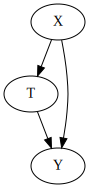

In [16]:
# Illustrate DGP with a DAG
g = gr.Digraph()
g.edge("X", "T")
g.edge("T", "Y")
g.edge("X", "Y")
g

## Monte Carlo Experiment

### case a : without control for the confounder

In [17]:
n_rep = 2000
tau = 2
N = [100,1000]
p = 1

estDict = run_mc_simulation(n_rep,tau,N,p,corr = 0.5,conf = True,conx = False,contf = False,contx = False)
summarize_mc_simulation(tau,n_rep,N,estDict)

100%|██████████| 2000/2000 [00:05<00:00, 379.86it/s]

N=100: bias=0.2797633839142419, RMSE=0.3272548560741808, size=0.549
N=1000: bias=0.28053376142696707, RMSE=0.3041396577949685, size=0.9425


### case b : with control for the confounder

In [18]:
n_rep = 2000
tau = 2
N = [100,1000]
p = 1

estDict = run_mc_simulation(n_rep,tau,N,p,corr = 0.5,conf = True,conx = False,contf = True,contx = False)
summarize_mc_simulation(tau,n_rep,N,estDict)

100%|██████████| 2000/2000 [00:05<00:00, 387.45it/s]

N=100: bias=0.2754015218224662, RMSE=0.32742354361862164, size=0.5315
N=1000: bias=0.2788108930331411, RMSE=0.3021648341841918, size=0.946


## Example

X : Average GDP of the region in the past 5 years.<br>
T : Whether to implement the subsidy policy.<br>
Y : Average salary of the region.<br>

# Q3
$y_i = \tau*T_i+ \beta'*x_i + e_i$

$x_i = \alpha*T_i+e_i$

In [19]:
## define a function to simulate selection data
def fn_selection_data(T,N,alpha):
    """
    alpha: 
    """
    
    err1 = np.random.normal(0,1,[N,1])
    X = alpha*T + err1

    return X

In [20]:
## define a function to simulate data y,T,x
def fn_generate_data(tau,N,p,corr,conf = True,conx = True,contf = True,contx = True):
    
    nvar = p+1 # 1 confounder
    
    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,0].reshape([N,1])
    
    T = fn_randomize_treatment(N)
    alpha = 2
    X = fn_selection_data(T,N,alpha)
    
    
    Y, T, X = fn_generate_y(T,X,C,tau,N,p,corr,conf,conx,contf,contx)
    
    return Y, T, X

In [21]:
# simulate a DGP
tau = 2
N = 100
p = 1

Y, T, X = fn_generate_data(tau,N,p,corr=0.5,conf = False,conx = True,contf = False,contx = True)

matrix = np.hstack([Y,T,X])
data_Q3 = pd.DataFrame(matrix, columns=['Y', 'T', 'X'])
data_Q3.to_csv("data_Q3.csv",index = False)

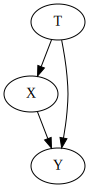

In [22]:
# Illustrate DGP with a DAG
g = gr.Digraph()
g.edge("T", "X")
g.edge("T", "Y")
g.edge("X", "Y")
g

## Monte Carlo Experiment

### case a : with control for the variable in between the path from cause to effect

In [23]:
n_rep = 2000
tau = 2
N = [100,1000]
p = 1

estDict = run_mc_simulation(n_rep,tau,N,p,corr = 0.5,conf = False,conx = True,contf = False,contx = True)
summarize_mc_simulation(tau,n_rep,N,estDict)

100%|██████████| 2000/2000 [00:18<00:00, 110.20it/s]

N=100: bias=10.004771024351054, RMSE=14.197929552751528, size=0.9895
N=1000: bias=9.784303134167619, RMSE=13.937558455241644, size=0.996


### case b : without control for the variable in between the path from cause to effect

In [24]:
n_rep = 2000
tau = 2
N = [100,1000]
p = 1

estDict = run_mc_simulation(n_rep,tau,N,p,corr = 0.5,conf = False,conx = True,contx = False,contf = False)
summarize_mc_simulation(tau,n_rep,N,estDict)

100%|██████████| 2000/2000 [00:18<00:00, 109.13it/s]

N=100: bias=9.866779127925662, RMSE=14.004831556549044, size=0.988
N=1000: bias=10.033161944867116, RMSE=14.148790493324872, size=0.997


## Example

T : Exercise every day or not.<br>
X : Drink more water.<br>
Y : Have a healthier body.<br>